<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/07_Food_Vision_Big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: 🍔👁 Food Vision Big™¶

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

This time we've got the goal of beating DeepFood, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.
https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
- Prefetching
- Mixed precision training

What we're going to cover:
1. Using TensorFlow Datasets to download and explore data
2. Creating preprocessing function for our data
3. Batching & preparing datasets for modelling (making our datasets run fast)
4. Creating modelling callbacks
5. Setting up mixed precision training
6. Building a feature extraction model 
7. Fine-tuning the feature extraction model
8. Viewing training results on TensorBoard


In [ ]:
# from google.colab import drive
# drive.mount('/content')

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-455307c5-a44c-0c22-3368-306b15a71760)


tf 2.5 has a bugs, so i need to downgrade to tf 2.4.1

In [ ]:
!pip3 install tensorflow==2.4.1

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.

### Imports and helper functions

In [ ]:
# Get helper functions
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-06-29 07:22:35--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-06-29 07:22:36 (81.1 MB/s) - ‘helper_functions.py’ saved [11016/11016]



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Activation
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomHeight, RandomRotation, RandomZoom, RandomWidth

In [ ]:
tf.__version__

'2.5.0'

### Helper functions

In [ ]:
def plot_loss_curves(history):
    """
    Args: TensorFlow model history object
    Returns: separate loss curves for training and validation metrics.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    #Plot Loss
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    #Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

### Get data
from tensorflow datasets

In [ ]:
import tensorflow_datasets.public_api as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [ ]:
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc']

In [ ]:
#Load in the data
(train_data_, test_data_), ds_info = tfds.load(name = 'food101', 
                                             split = ['train', 'validation'],
                                             as_supervised = True,
                                             shuffle_files = True, #I changed to false to check predictions
                                             with_info = True,
                                             see)

In [ ]:
test_data_

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

 Note: Calling the tfds.load() method will start to download a target dataset to disk if the download=True parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
labels = ds_info.features['label'].names

In [ ]:
labels[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data_

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
train_data_.take(1)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
train_one_sample = train_data_.take(1)

In [ ]:
for image, label in train_one_sample:
  print('Image shape:', image.shape)
  print('Image datatype:', image.dtype)
  print('Target class:', label)
  print('Class Name:', labels[label.numpy()])

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class: tf.Tensor(56, shape=(), dtype=int64)
Class Name: huevos_rancheros


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(y_pred, y_test, figsize = (10, 10), classes = False, text_size = 6):
  # Create the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ax.tick_params(axis='x', labelrotation= 90) 

  # Adjust label size
  ax.xaxis.label.set_size(20)
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)


In [ ]:
#Labels are not one hot encoded

In [ ]:
image, tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[233, 253, 251],
         [231, 253, 250],
         [228, 254, 251],
         ...,
         [ 85,  82,  89],
         [ 68,  67,  75],
         [ 57,  57,  67]],
 
        [[232, 254, 252],
         [229, 254, 251],
         [226, 255, 251],
         ...,
         [121, 116, 120],
         [100,  99, 104],
         [ 86,  85,  91]],
 
        [[228, 254, 253],
         [226, 255, 253],
         [223, 255, 252],
         ...,
         [164, 159, 155],
         [145, 141, 138],
         [128, 127, 125]],
 
        ...,
 
        [[ 66, 112, 164],
         [ 67, 113, 163],
         [ 55,  99, 148],
         ...,
         [  5,  14,  23],
         [  9,  18,  27],
         [  8,  17,  26]],
 
        [[ 76, 123, 177],
         [ 75, 122, 176],
         [ 70, 116, 168],
         ...,
         [  5,  14,  23],
         [  9,  18,  25],
         [  7,  16,  23]],
 
        [[ 80, 129, 185],
         [ 71, 121, 174],
         [ 74,

(-0.5, 511.5, 511.5, -0.5)

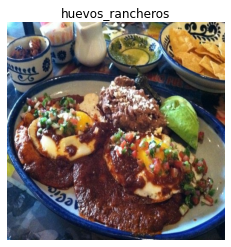

In [ ]:
#Plot this picture
plt.imshow(image)
plt.title(labels[label.numpy()])
plt.axis(False)

### Make a function for preprocessing images

In [ ]:
def prep_img(img, label, img_shape = 224):
  """
  Convert image datatype tp float32 and reshapes to [img_shape, img_shape, color]
  """
  img = tf.image.resize(img, [img_shape, img_shape])
  img = tf.cast(img, dtype = tf.float32)
  return img, label

In [ ]:
img, label = prep_img(image, label)

In [ ]:
img.shape

TensorShape([224, 224, 3])

### Batch and prepare datasets

In [ ]:
#Map preprocessing function
train_data = train_data_.map(map_func=prep_img, num_parallel_calls=tf.data.AUTOTUNE) #num_parallel_calls=tf.data.AUTOTUNE to get all computing resurses
#Make butches and shuffle again
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#Same with test data, but without shuffle
test_data = test_data_.map(map_func=prep_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Create modeling callbacks

In [ ]:
def create_checkpoint(model_name):
  """Returns checkpoint callback function, args: model number"""
  checkpoint_filepath = 'checkpoints/checkpoint_'+model_name+'.ckpt'
  model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                                          save_weights_only=True, save_freq='epoch',
                                                          options=None)
  return model_checkpoints

def early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          min_delta=0, 
                                          patience=2, 
                                          verbose=0,
                                          mode='auto', 
                                          baseline=None, 
                                          restore_best_weights=False)
import datetime
def create_tf_board_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorflow_callback

### Set up mixed precision training

In [ ]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Building feature extraction model

In [ ]:
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

In [ ]:
inputs = Input(shape = (224,224,3), name = 'input_layer')
gap_layer = GlobalAveragePooling2D(name = 'global_average_pooling')
dense = Dense(len(labels))
outputs = Activation(activation = 'softmax', dtype = tf.float32, name = 'output')

In [ ]:
x = base_model(inputs, training = False)
x = gap_layer(x)
x = dense(x)
outputs = outputs(x)
model = Model(inputs, outputs)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
output (Activation)          (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
output True float32 <Policy "float32">


In [ ]:
history_features = model.fit(train_data,
                             epochs = 5,
                             validation_data = test_data,
                             steps_per_epoch = len(train_data),
                             validation_steps = int(0.15*len(test_data)),
                             callbacks = [create_checkpoint('feature_extr_1'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'feature_extr')])

Saving TensorBoard log files to efficientnetB0_full/feature_extr/20210629-080258
Epoch 1/5
2368/2368 [==============================] - 230s 90ms/step - loss: 2.3373 - accuracy: 0.4620 - val_loss: 1.2329 - val_accuracy: 0.6711

Epoch 00001: val_loss improved from inf to 1.23293, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 2/5
2368/2368 [==============================] - 211s 88ms/step - loss: 1.3292 - accuracy: 0.6559 - val_loss: 1.1251 - val_accuracy: 0.7058

Epoch 00002: val_loss improved from 1.23293 to 1.12507, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 3/5
2368/2368 [==============================] - 166s 69ms/step - loss: 1.1665 - accuracy: 0.6937 - val_loss: 1.0841 - val_accuracy: 0.7079

Epoch 00003: val_loss improved from 1.12507 to 1.08407, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 4/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.0630 - accuracy: 0.7221 - val_loss: 1.0750 - val_accuracy

In [ ]:
result_feature_extr = model.evaluate(test_data)
result_feature_extr

790/790 [==============================] - 60s 76ms/step - loss: 1.0727 - accuracy: 0.7101


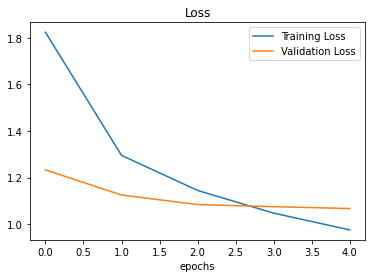

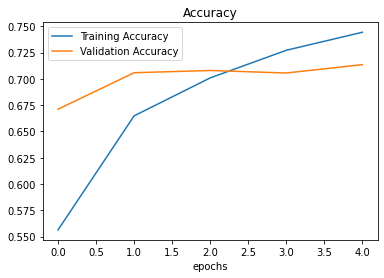

In [ ]:
plot_loss_curves(history_features)

In [ ]:
model.save('/content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e/assets


### Fine tuning our model 10 layers unfrozen 5 epochs

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/model_food101_feature_extr_5e')

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

In [ ]:
history_fine_tuned_1 = model.fit(train_data, epochs = 10,
                               initial_epoch = 5,
                               validation_data = test_data,
                               steps_per_epoch = len(train_data),
                               validation_steps = int(0.15*len(test_data)),
                               callbacks = [create_checkpoint('fine_tune'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'fine_tune')])

Saving TensorBoard log files to efficientnetB0_full/fine_tune/20210629-090757
Epoch 6/10
2368/2368 [==============================] - 310s 125ms/step - loss: 0.9194 - accuracy: 0.7506 - val_loss: 0.8670 - val_accuracy: 0.7619

Epoch 00006: val_loss improved from inf to 0.86700, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 7/10
2368/2368 [==============================] - 293s 123ms/step - loss: 0.5481 - accuracy: 0.8496 - val_loss: 0.8861 - val_accuracy: 0.7606

Epoch 00007: val_loss did not improve from 0.86700
Epoch 8/10
2368/2368 [==============================] - 293s 123ms/step - loss: 0.3031 - accuracy: 0.9141 - val_loss: 0.9976 - val_accuracy: 0.7654

Epoch 00008: val_loss did not improve from 0.86700


Early stopping broke training process on 08 epoch because val_loss didnt improved. I will download weights from last checkpoint and do another training with all layers in base model unfrozen plus reducing learning rate

Our model performes better (0.7101 - 0.7648)

In [ ]:
result_fine_tuned_1 = model.evaluate(test_data)
result_fine_tuned_1

790/790 [==============================] - 49s 61ms/step - loss: 0.9866 - accuracy: 0.7648


[0.9865905046463013, 0.7648316621780396]

5
8
[0.5562904477119446, 0.6647788882255554, 0.7008448839187622, 0.7271155118942261, 0.7442640066146851, 0.7685280442237854, 0.8582574129104614, 0.9215709567070007]


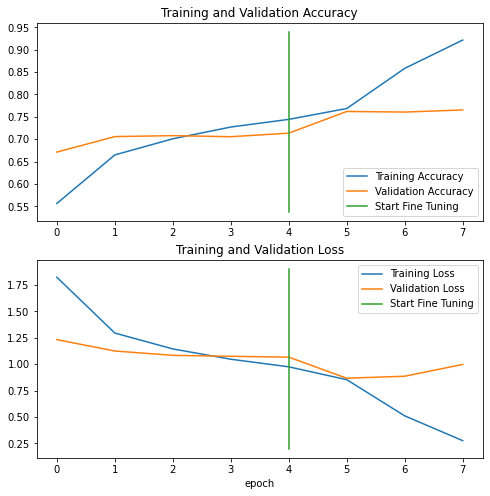

In [ ]:
#History of feature extraction and fine tuning models
compare_historys(history_features, history_fine_tuned_1, initial_epochs=5)

In [ ]:
model.save('/content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_1_10e')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_1_10e/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_1_10e/assets


### Train same model for another 5 epochs

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy',
#               metrics = 'accuracy')

In [ ]:
# history_fine_tuned_2 = model.fit(train_data, epochs = 15,
#                               initial_epoch=10,
#                                validation_data = test_data,
#                                steps_per_epoch = len(train_data),
#                                validation_steps = int(0.15*len(test_data)),
#                                callbacks = [create_checkpoint('fine_tune'),
#                                             early_stopping(),
#                                             create_tf_board_callback('efficientnetB0_full', 'fine_tune')])

Saving TensorBoard log files to efficientnetB0_full/fine_tune/20210629-092420
Epoch 11/15
2368/2368 [==============================] - 308s 125ms/step - loss: 0.1693 - accuracy: 0.9484 - val_loss: 1.1128 - val_accuracy: 0.7662

Epoch 00011: val_loss improved from inf to 1.11282, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 12/15
2025/2368 [========================>.....] - ETA: 41s - loss: 0.1031 - accuracy: 0.9685

KeyboardInterrupt: ignored

In [ ]:
# result_fine_tuned_2 = model.evaluate(test_data)
# result_fine_tuned_2

Our accuracy even dropped down from 0.7269 to 0.7197

In [ ]:
# #History of feature extraction and fine tuning models
# compare_historys(history_fine_tuned_1, history_fine_tuned_2, initial_epochs=5)

In [ ]:
# model.save('/content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_2_15e')

### ReduceLROnPlateau callback
I add this function, unfreeze all layers in base model and try for another 20 epochs.

Tf will automatically reduce learning rate if we reach plateau in val_loss

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
model.load_weights('/content/checkpoints/checkpoint_fine_tune.ckpt')

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                            loss = 'sparse_categorical_crossentropy',
                            metrics = 'accuracy')

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling True
dense_1 True
output True


In [ ]:
history_fine_tuned_3 = model.fit(train_data, epochs = 20,
                                initial_epoch=15,
                                validation_data = test_data,
                                steps_per_epoch = len(train_data),
                                validation_steps = int(0.15*len(test_data)),
                                callbacks = [create_checkpoint('fine_tune_all_unfreezed'),
                                              early_stopping(),
                                              create_tf_board_callback('efficientnetB0_full', 'fine_tune'),
                                              reduce_lr])

Saving TensorBoard log files to efficientnetB0_full/fine_tune/20210629-093846
Epoch 16/20
2368/2368 [==============================] - 309s 125ms/step - loss: 0.1061 - accuracy: 0.9680 - val_loss: 1.1582 - val_accuracy: 0.7691

Epoch 00016: val_loss improved from inf to 1.15815, saving model to checkpoints/checkpoint_fine_tune_all_unfreezed.ckpt
Epoch 17/20
2368/2368 [==============================] - 294s 123ms/step - loss: 0.0854 - accuracy: 0.9729 - val_loss: 1.2474 - val_accuracy: 0.7648

Epoch 00017: val_loss did not improve from 1.15815
Epoch 18/20
2368/2368 [==============================] - 293s 123ms/step - loss: 0.0731 - accuracy: 0.9769 - val_loss: 1.2688 - val_accuracy: 0.7672

Epoch 00018: val_loss did not improve from 1.15815

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.


In [ ]:
result_fine_tuned_3 = model.evaluate(test_data)
result_fine_tuned_3

790/790 [==============================] - 57s 72ms/step - loss: 1.2581 - accuracy: 0.7671


[1.2581398487091064, 0.7670891284942627]

I could not beat the results of 77%.
I will try to do it slightly another way in another notebook

3
6
[0.7685280442237854, 0.8582574129104614, 0.9215709567070007, 0.9682904481887817, 0.975023090839386, 0.9771353006362915]


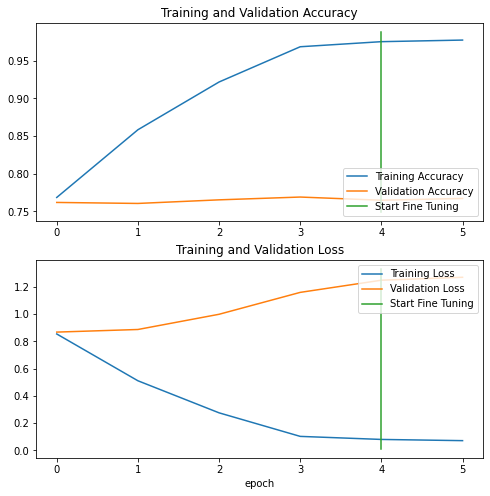

In [ ]:
compare_historys(history_fine_tuned_1, history_fine_tuned_3, initial_epochs=5)

In [ ]:
model.save('/content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_3_20e')

### View training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./efficientnetB0_full \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data" \
  --one_shot

Done. View your TensorBoard at https://tensorboard.dev/experiment/2SpoZnT2TN2ep0gPJocYVg/

### Make predictions and evaluate our model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/model_food101_fine_tuned_3_20e')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
pred_probs = model.predict(test_data)

In [ ]:
preds = np.array(tf.argmax(pred_probs, axis = 1))

### Get labels

In [ ]:
labels_test = []
n=100
for img, label in test_data.unbatch():
  if n>=0:
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, dtype = tf.float32) 
    img = tf.expand_dims(img, axis =0)
    pred_prob = model.predict(img)
    pred = np.array(tf.argmax(pred_prob, axis = 1))
    print(label, pred)
    n=n-1
  else:
    break  

*I don't understand*
If i predict all test data and get labels from test data

In [ ]:
labels_test = []
for img, label in test_data.unbatch():
  labels_test.append(label.numpy())


In [ ]:
np.array(labels_test[50:100])

array([ 98,  40,  60,  13,  36,  92,  21,  25,  29,  81,  66,  81,   1,
        92,  83,  16,  60,  32,  36,  94,  48,   0,  65,  29,  56,  37,
        87,  65,  64,  26,   1,  75,  61,  74,  54,  76,  34,  90,  15,
         4,  15,  19,  49, 100,  93,  62,  37,  99,  40,  60])

In [ ]:
preds[50:100]

array([ 39,  40,  60,  13,  96,   2,  22,  25,  22,  64,  51,  81,   1,
        92,  83,  16,  60,  22,  36,  94,  48,  14,  65,  29,   9,  79,
        89,  65,  64,  37,   1,  81,  61,  74,  54,  76,  82,  90,  15,
         4,  15,  19,  48, 100,  93,  62,  37,  99,  62,  60])

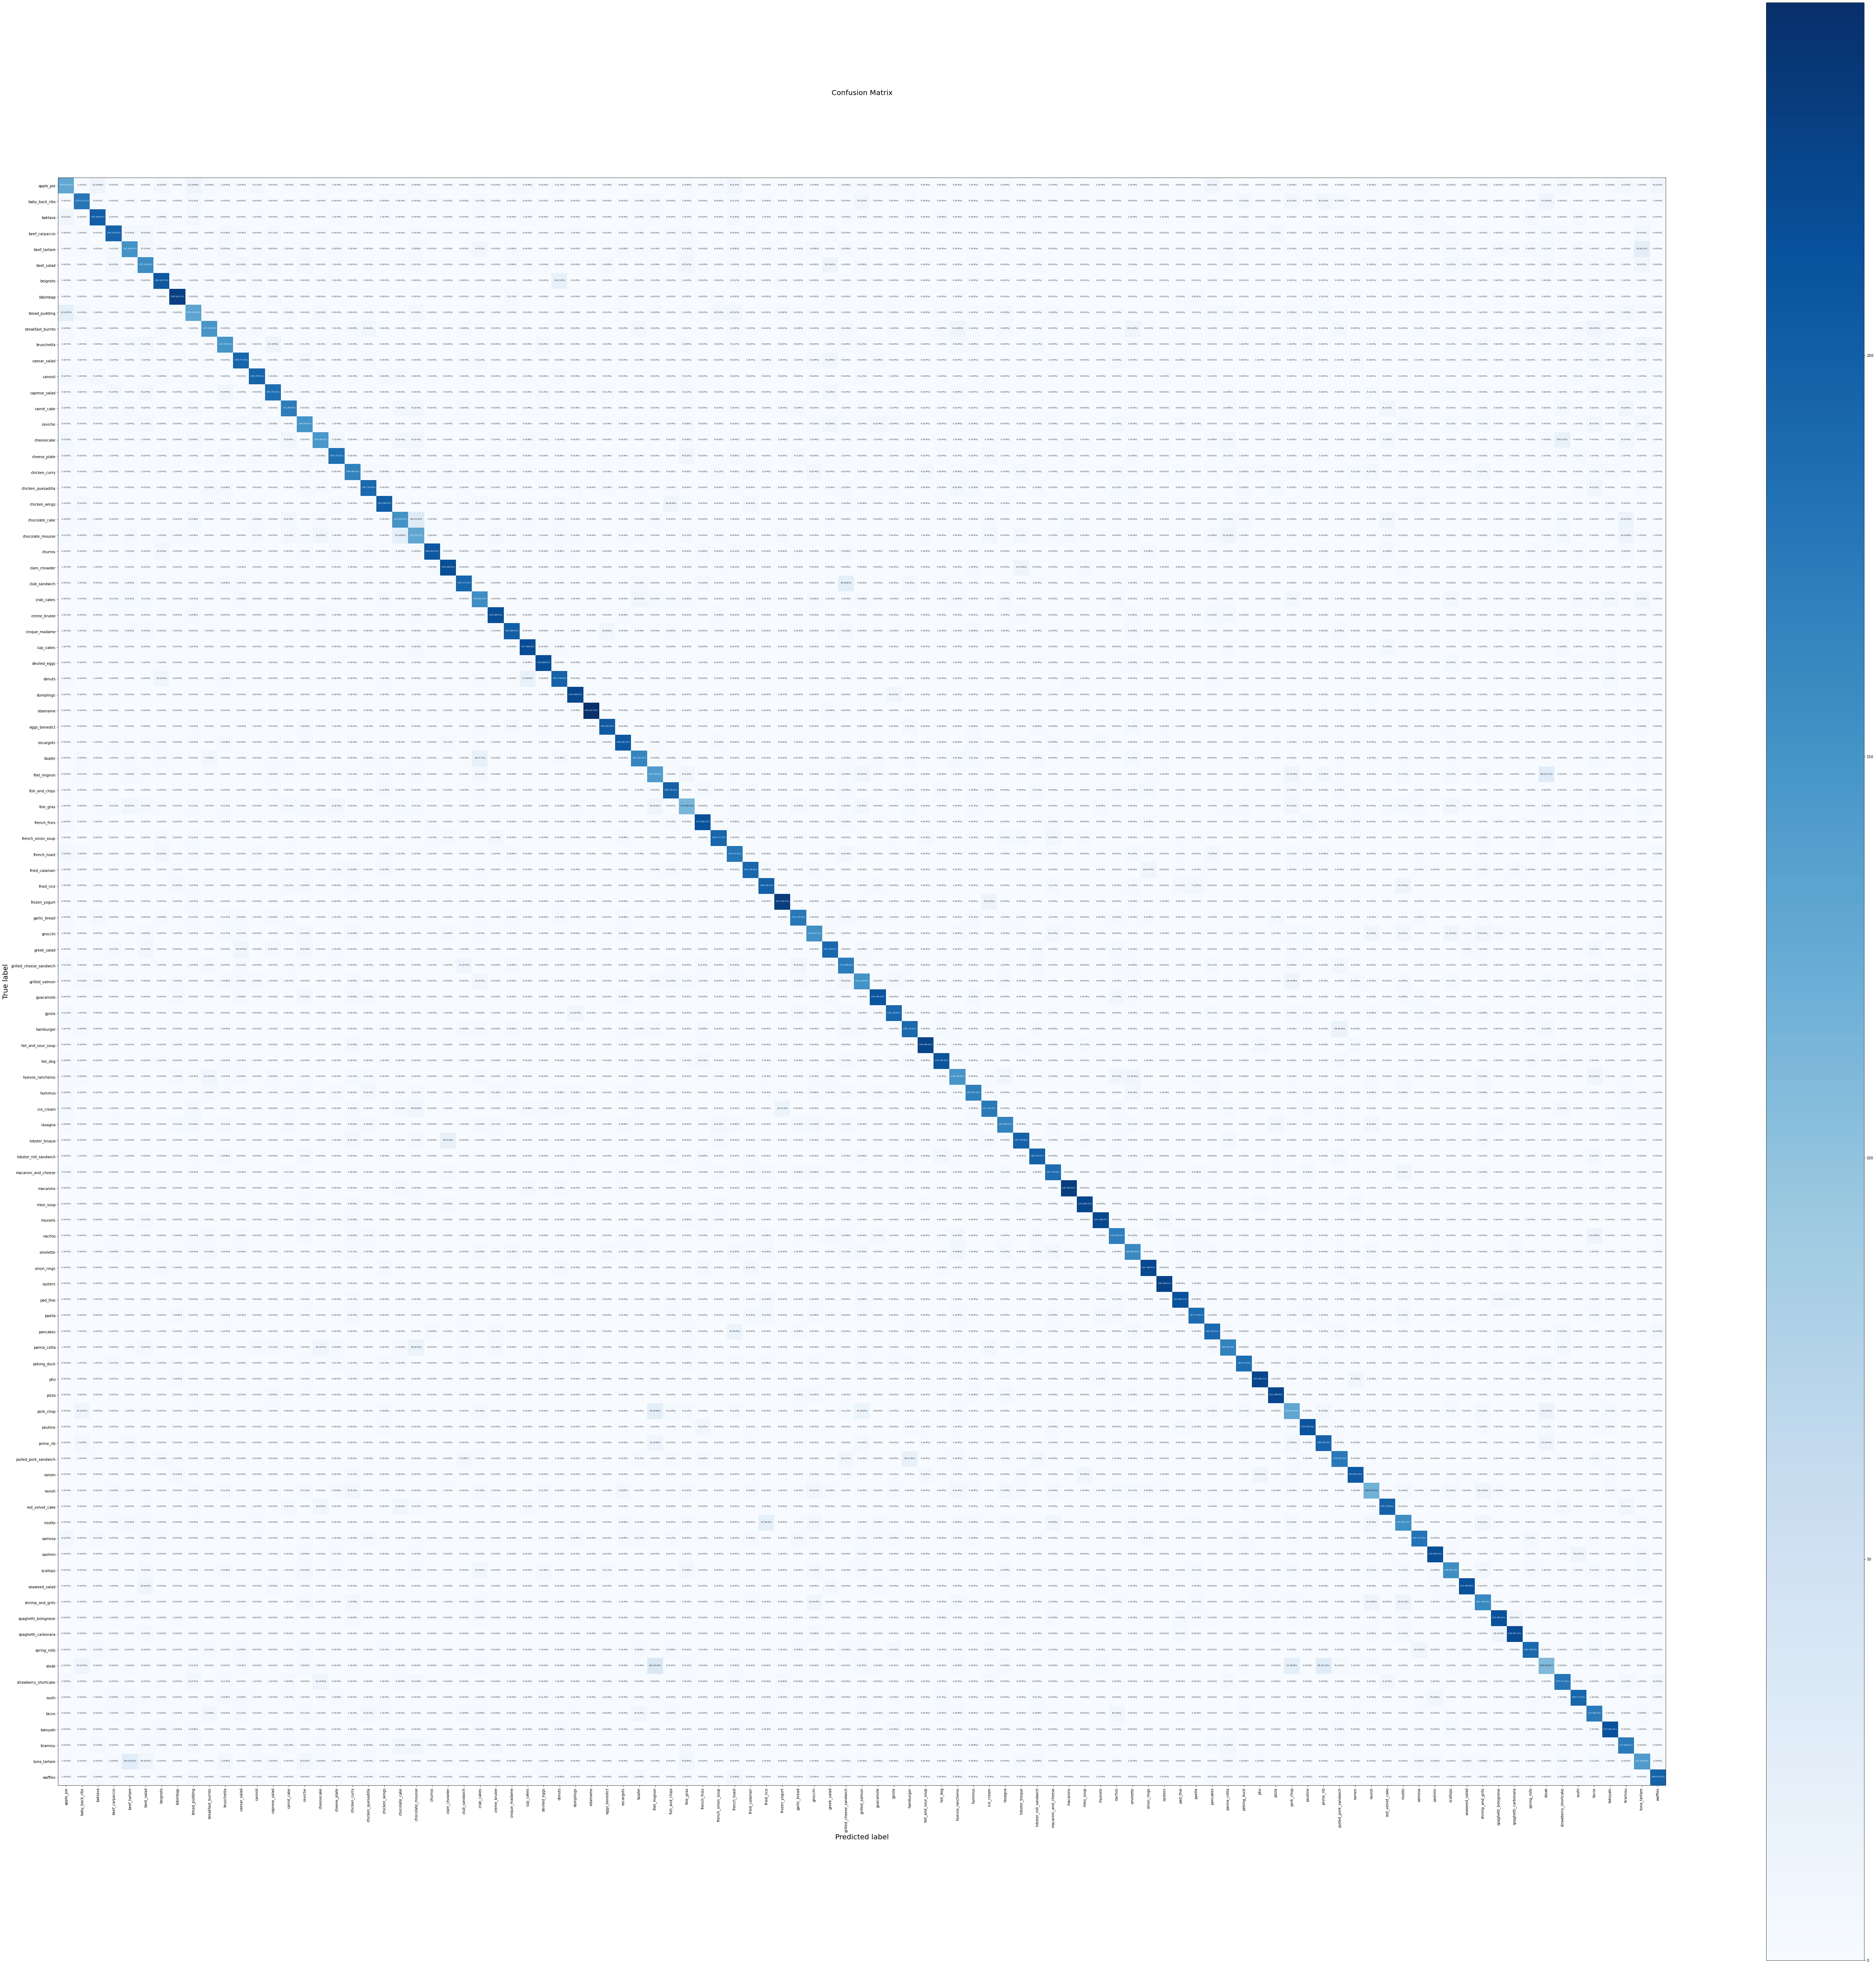

In [ ]:
plot_confusion_matrix(preds, labels_test, figsize = (100,100), classes = labels)

### Classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
class_report = classification_report(y_test, preds, output_dict=True)

In [ ]:
report = {}
for key, item in class_report.items():
  if key == 'accuracy':
    break
  report[key] = [labels[int(key)], round(item['f1-score'],2)]

In [ ]:
report_df = pd.DataFrame.from_dict(report, orient='index', columns = ['name', 'f1-score'])
report_df = report_df.sort_values('f1-score', ascending = True)
report_df

### Plot class report